In [26]:
import os
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from tqdm.notebook import tqdm
from openTSNE import TSNE
import datashader as ds
import colorcet as cc

from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import dask_ml.feature_extraction.text
import dask.bag as db

from transformers import AutoTokenizer
from huggingface_hub import notebook_login, HfApi, hf_hub_download, Repository
from datasets import load_dataset
from datasets.utils.py_utils import convert_file_size_to_int

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom")
vocab = tokenizer.vocab
reverse_vocab = {v:k for k,v in vocab.items()}

In [1]:
def batch_tokenize(batch):
    return {'tokenized': [' '.join(e.tokens) for e in tokenizer(batch['text']).encodings]}

In [5]:
dset_name = "bigscience-catalogue-lm-data/roots_fr_uncorpus"

In [9]:
dset = load_dataset(dset_name, split="train", cache_dir="/media/ssd/BIGSCIENCE/cache")

Using custom data configuration bigscience-catalogue-lm-data--cleaned_lm_fr_uncorpus-df68e40301b12c79
Reusing dataset parquet (/media/ssd/BIGSCIENCE/cache/bigscience-catalogue-lm-data___parquet/bigscience-catalogue-lm-data--cleaned_lm_fr_uncorpus-df68e40301b12c79/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [12]:
dset

Dataset({
    features: ['text', 'meta'],
    num_rows: 145876
})

In [15]:
%%time
dset = dset.map(batch_tokenize, batched=True, batch_size=64, num_proc=28)

#0:   0%|          | 0/82 [00:00<?, ?ba/s]

#2:   0%|          | 0/82 [00:00<?, ?ba/s]

#1:   0%|          | 0/82 [00:00<?, ?ba/s]

#3:   0%|          | 0/82 [00:00<?, ?ba/s]

#4:   0%|          | 0/82 [00:00<?, ?ba/s]

#5:   0%|          | 0/82 [00:00<?, ?ba/s]

#6:   0%|          | 0/82 [00:00<?, ?ba/s]

#7:   0%|          | 0/82 [00:00<?, ?ba/s]

#8:   0%|          | 0/82 [00:00<?, ?ba/s]

#9:   0%|          | 0/82 [00:00<?, ?ba/s]

#10:   0%|          | 0/82 [00:00<?, ?ba/s]

#11:   0%|          | 0/82 [00:00<?, ?ba/s]

#12:   0%|          | 0/82 [00:00<?, ?ba/s]

#13:   0%|          | 0/82 [00:00<?, ?ba/s]

#14:   0%|          | 0/82 [00:00<?, ?ba/s]

#15:   0%|          | 0/82 [00:00<?, ?ba/s]

#16:   0%|          | 0/82 [00:00<?, ?ba/s]

#17:   0%|          | 0/82 [00:00<?, ?ba/s]

#18:   0%|          | 0/82 [00:00<?, ?ba/s]

#20:   0%|          | 0/82 [00:00<?, ?ba/s]

#19:   0%|          | 0/82 [00:00<?, ?ba/s]

#21:   0%|          | 0/82 [00:00<?, ?ba/s]

#22:   0%|          | 0/82 [00:00<?, ?ba/s]

#24:   0%|          | 0/82 [00:00<?, ?ba/s]

#23:   0%|          | 0/82 [00:00<?, ?ba/s]

#25:   0%|          | 0/82 [00:00<?, ?ba/s]

#26:   0%|          | 0/82 [00:00<?, ?ba/s]

#27:   0%|          | 0/82 [00:00<?, ?ba/s]

CPU times: user 10.8 s, sys: 2.33 s, total: 13.2 s
Wall time: 4min 11s


In [29]:
%%time
max_shard_size = convert_file_size_to_int('300MB')
dataset_nbytes = dset.data.nbytes
num_shards = int(dataset_nbytes / max_shard_size) + 1
num_shards = max(num_shards, 1)
print(f"Sharding into {num_shards} files.")
os.makedirs(f"{dset_name}/tokenized", exist_ok=True)
for shard_index in tqdm(range(num_shards)):
    shard = dset.shard(num_shards=num_shards, index=shard_index, contiguous=True)
    shard.to_parquet(f"{dset_name}/tokenized/tokenized-{shard_index:03d}.parquet")
os.listdir(f'{dset_name}/tokenized/')

Sharding into 43 files.


  0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 30 s, sys: 2.43 s, total: 32.4 s
Wall time: 32.2 s


['tokenized-013.parquet',
 'tokenized-037.parquet',
 'tokenized-024.parquet',
 'tokenized-032.parquet',
 'tokenized-027.parquet',
 'tokenized-007.parquet',
 'tokenized-028.parquet',
 'tokenized-005.parquet',
 'tokenized-029.parquet',
 'tokenized-010.parquet',
 'tokenized-004.parquet',
 'tokenized-003.parquet',
 'tokenized-016.parquet',
 'tokenized-040.parquet',
 'tokenized-031.parquet',
 'tokenized-012.parquet',
 'tokenized-030.parquet',
 'tokenized-041.parquet',
 'tokenized-017.parquet',
 'tokenized-034.parquet',
 'tokenized-020.parquet',
 'tokenized-026.parquet',
 'tokenized-015.parquet',
 'tokenized-014.parquet',
 'tokenized-011.parquet',
 'tokenized-022.parquet',
 'tokenized-009.parquet',
 'tokenized-036.parquet',
 'tokenized-025.parquet',
 'tokenized-018.parquet',
 'tokenized-039.parquet',
 'tokenized-042.parquet',
 'tokenized-001.parquet',
 'tokenized-021.parquet',
 'tokenized-023.parquet',
 'tokenized-006.parquet',
 'tokenized-000.parquet',
 'tokenized-033.parquet',
 'tokenized-

In [4]:
client = Client()
client

<Client: 'tcp://127.0.0.1:34657' processes=7 threads=28, memory=62.60 GiB>

In [6]:
%%time
df = dd.read_parquet(f'{dset_name}/tokenized/')
vect = dask_ml.feature_extraction.text.CountVectorizer(tokenizer=str.split,
                                                       token_pattern=None,
                                                       vocabulary=vocab)
tokenized_bag = df['tokenized'].to_bag()
X = vect.transform(tokenized_bag)

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 9.24 s, sys: 742 ms, total: 9.98 s
Wall time: 23 s


In [10]:
%%time
counts = X.compute()
client.shutdown()

distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


CPU times: user 39.8 s, sys: 5.9 s, total: 45.7 s
Wall time: 2min 39s


In [14]:
counts

<145876x250680 sparse matrix of type '<class 'numpy.int64'>'
	with 43446986 stored elements in Compressed Sparse Row format>

In [11]:
freq = counts.sum(axis=0).A1
frequencies = Counter({reverse_vocab[i]:freq[i] for i in freq.nonzero()[0]})
frequencies.most_common(100)

[(',', 34814464),
 ('.', 21948181),
 (')', 4949061),
 (';', 2740524),
 ('ant', 1231074),
 ('1', 1134577),
 ('),', 1117959),
 ('le', 1042373),
 ('e', 996400),
 ('ation', 976949),
 ('2', 965098),
 ('/', 901092),
 ('b', 810668),
 ('a', 801115),
 ('s', 752845),
 ('ent', 749895),
 ('3', 714091),
 ('c', 675251),
 ('er', 653847),
 ('ement', 650192),
 (':', 646632),
 ('ie', 639917),
 ('la', 623993),
 ('4', 607453),
 ('ations', 604552),
 ('es', 563981),
 ('m', 559806),
 ('d', 554653),
 ('i', 544907),
 ('les', 541236),
 ('is', 514949),
 (').', 501087),
 ('5', 494491),
 ('isation', 488711),
 ('en', 487799),
 ('"', 473312),
 ('un', 462088),
 ('6', 418736),
 ('aient', 409955),
 ('f', 409463),
 ('g', 399877),
 ('ait', 391162),
 ('r', 387126),
 ('ants', 384791),
 ('>>', 376997),
 ('us', 366909),
 ('ique', 359072),
 ('n', 343549),
 ('de', 342141),
 ('7', 339226),
 ('-', 338144),
 ('aux', 336640),
 ('v', 330524),
 ('ements', 303551),
 ("l'", 302513),
 ('il', 302115),
 ('ies', 300399),
 ('it', 299106),


In [17]:
%%time
tfidf = tfidf_transformer.fit_transform(counts)

CPU times: user 994 ms, sys: 116 ms, total: 1.11 s
Wall time: 1.06 s


In [21]:
%%time
svd = TruncatedSVD(n_components=160)
X = svd.fit_transform(tfidf)

CPU times: user 3min 37s, sys: 1min, total: 4min 38s
Wall time: 1min 7s


In [24]:
tsne = TSNE(
    perplexity=30,
    metric="cosine",
    n_jobs=28,
    random_state=42,
    verbose=True,
)

In [25]:
%%time 
tsne_embedding = tsne.fit(X)

--------------------------------------------------------------------------------
TSNE(metric='cosine', n_jobs=28, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 31.83 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.62 seconds
===> Running optimization with exaggeration=12.00, lr=12156.33 for 250 iterations...
Iteration   50, KL divergence 8.0172, 50 iterations in 3.3109 sec
Iteration  100, KL divergence 7.6925, 50 iterations in 3.2977 sec
Iteration  150, KL divergence 7.5762, 50 iterations in 3.3080 sec
Iteration  200, KL divergence 7.5796, 50 iterations in 3.3637 sec
Iteration  250, KL divergence 7.5440, 50 iterations in 3.3075 sec
   --> Time elapsed: 16.59 seconds
===> Running optimization with exaggeration=1.00, 

In [28]:
df = pd.DataFrame(data=tsne_embedding, columns=['x','y'])

CPU times: user 44.5 ms, sys: 16 µs, total: 44.5 ms
Wall time: 40.2 ms


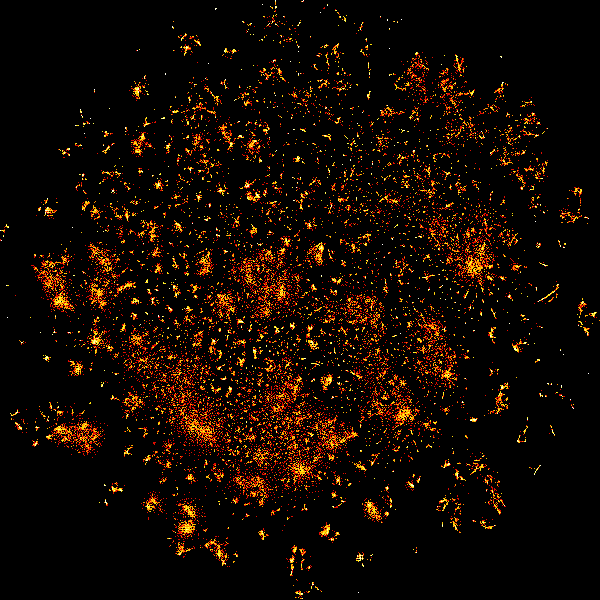

In [31]:
%%time

agg = ds.Canvas(plot_height=600, plot_width=600).points(df, 'x', 'y')
img = ds.tf.shade(agg, cmap=cc.fire, how='eq_hist')
ds.tf.set_background(img, "black")